TAKURA WEKWETE (STUDENT NO u21717215)
MASTERS MIT BIG DATA SCIENCE 

NOVEMBER 2022 (TAKURAWEKWETE@GMAIL.COM OR u21717215@tuks.co.za)

CODE FOR CHAPTER 6


In [3]:
# Load reinfocement learning libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import random
import scipy.stats as stats
import seaborn as sns
from IPython.core.debugger import set_trace

#Import Model Packages for reinforcement learning
from keras import layers, models, optimizers
from keras import backend as K
import tensorflow as tf
from collections import namedtuple, deque

In [2]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
tf.version.VERSION

'1.13.1'

In [5]:
#MODEL RECORD
#THIS IS MODEL 6

TRADITIONAL SOLUTION BASED ON ANALYTICAL APPROACH

In [6]:
#The function below does immunisation by solving 2 simultaneous equations 1)PV(Assets)=PV(Liabilities) and 2) Duration(Assets)=Duration(Liabilities)
def zc_immuniser(m1,m2,liab_duration):  #m1=maturity for zero coupon bond 1 and m2 for zero coupon bond 2
    A=[[1,1],[m1,m2]]
    B=[1,liab_duration] 
    x=np.linalg.solve(A,B)
    #W1=x[0] #bond 1 allocation
    #print("Bond 1 allocation is",np.round(W1*100,2),"%")
    #W2=x[1] #bond 2 allocation 
    #print("Bond 2 allocation is",np.round(W2*100,2),"%")
    weight1_interim=x[0]
    weight2_interim=x[1]
    weight1=min(max(weight1_interim,0),1)
    weight2=min(max(weight2_interim,0),1)
    result=np.array([m1,m2,liab_duration,weight1,weight2])
    return result


FUNCTIONS WHICH GENERATE MONTE CARLO  SIMULATIONS FOR A SPECIFIED NUMBER OF REQUIRED SIMULATIONS

In [7]:
def liability_duration_sim(steps,prob_increase,max_change,duration_start):
    
    duration_change_sign = np.random.choice(a=([1,-1]),p=([prob_increase,1-prob_increase]),size=steps)#increase or decrease 
    magnitude_of_duration_change =np.random.uniform(low=0,high=max_change,size=steps) 
    duration_change = duration_change_sign*magnitude_of_duration_change
    cumulative_duration_change=np.cumsum(duration_change)
    liab_duration_sim=duration_start+cumulative_duration_change

    return(liab_duration_sim)

In [8]:
def asset_term_sim(steps,change_sign,change_size,term_range_start,term_range_end):
    
    term_start = np.random.uniform(low=term_range_start,high=term_range_end,size=1) 
    change_sign_array = np.full((steps,),change_sign) 
    term_change = change_sign_array*change_size
    cumulative_term_change = np.cumsum(term_change)
    asset_term_sim = term_start+cumulative_term_change

    return(asset_term_sim)

In [9]:
def generate_one_simulation(steps,prob_increase,max_change,duration_start):
    one_liability_simulation=liability_duration_sim(steps,prob_increase,max_change,duration_start)
    one_asset1_simulation = asset_term_sim(steps,0,0,10,20)
    one_asset2_simulation = asset_term_sim(steps,0,0,30,40)
    one_simulation = np.stack((one_asset1_simulation,one_asset2_simulation,one_liability_simulation),axis=1)
    return(one_simulation)


In [76]:
def generate_multiple_simulations(steps,number_simulations,max_change=2,duration_start=25):

    first_simulation = generate_one_simulation(steps,0.5,max_change,duration_start)
    first_simulation_reshaped = np.reshape(first_simulation,(1,first_simulation.shape[0],first_simulation.shape[1]))
    multiple_simulations = first_simulation_reshaped
    
    for i in np.arange(start=1,stop=number_simulations):
        prob_inc=np.random.uniform(low=0.3,high=0.7)   #specifying the ranges of drift
        ith_simulation = generate_one_simulation(steps,prob_inc,max_change,duration_start)
        ith_simulation_reshaped = np.reshape(ith_simulation,(1,ith_simulation.shape[0],ith_simulation.shape[1]))
        multiple_simulations = np.concatenate((multiple_simulations,ith_simulation_reshaped),axis=0)
    
    multiple_simulations = np.transpose(multiple_simulations,axes=(1,0,2))
    return(multiple_simulations)

In [80]:
training_simulation=generate_multiple_simulations(steps=30,number_simulations=50000,max_change=2)
training_simulation.shape

(30, 50000, 3)

<function matplotlib.pyplot.show(close=None, block=None)>

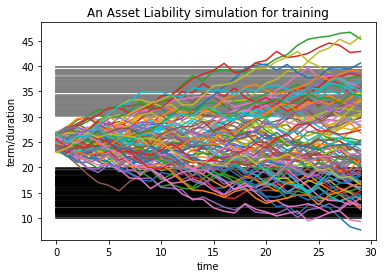

In [81]:
asset1term=training_simulation[:,0:100,0]
asset2term=training_simulation[:,0:100,1]
liabilities_duration=training_simulation[:,0:100,2]
plt.plot(asset1term,color ="black")
plt.plot(asset2term,color = "grey")
plt.plot(liabilities_duration)
plt.xlabel("time")
plt.ylabel("term/duration")
plt.title("An Asset Liability simulation for training")
plt.show

TASK 2: ALM DEEP REINFORCEMENT LEARNING 

In [152]:
#DEFINING REINFORCEMENT LEARNING AGENT FOR ALM 
from IPython.core.debugger import set_trace

class ALM_Agent(object):
    def __init__(self, time_steps, batch_size, features, nodes = [62,46,46,1], name='alm_model'):
        tf.reset_default_graph()
        self.batch_size = batch_size 
        self.alm_input = tf.placeholder(tf.float32, [time_steps, batch_size, features]) 

        self.asset1= self.alm_input[:,:,0]
        self.asset2= self.alm_input[:,:,1]
        self.liabilities= self.alm_input[:,:,2]

        alm_input_mod = tf.unstack(self.alm_input, axis=0)

        # Build the lstm
        lstm = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(n) for n in nodes])

        self.strategy, state = tf.nn.static_rnn(lstm, alm_input_mod, initial_state=lstm.zero_state(batch_size, tf.float32), dtype=tf.float32)
        #self.strategy = tf.contrib.layers.fully_connected(inputs=alm_input_mod, num_outputs=1,activation_fn=tf.nn.relu)

        self.strategy_mod = tf.reshape(self.strategy, (time_steps, batch_size))

        self.asset1_weight=self.strategy_mod
        self.asset2_weight=tf.ones([time_steps, batch_size], dtype=tf.float32)-self.strategy_mod

        self.errors=tf.math.multiply( self.asset1_weight, self.asset1) + tf.math.multiply(self.asset2_weight, self.asset2) -  self.liabilities  #- tf.ones([time_steps, batch_size], dtype=tf.float32)     #duration mismatch errors
        self.errors_squared = tf.abs( self.errors)  #Sum square errors
        self.SSE = tf.reduce_sum(self.errors_squared,axis=0)      
        BATCH_SSE = tf.reduce_mean(self.SSE)

        self.train = tf.train.AdamOptimizer().minimize(BATCH_SSE) #Dynamic learning rate 
        #self.train = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(BATCH_SSE) #Synonymous with Stochastic Gradient descent 
        #self.train = tf.train.ProximalGradientDescentOptimizer(learning_rate=0.01).minimize(BATCH_SSE) #Synonymous with Stochastic Gradient descent 

        self.saver = tf.train.Saver()
        self.modelname = name
        
    def _execute_graph_batchwise(self, paths, sess, epochs=1, train_flag=False):
        sample_size = paths.shape[1]
        batch_size=self.batch_size
        idx = np.arange(sample_size)
        start = dt.datetime.now()
        for epoch in range(epochs):
            # Save the ALM mismatch errors for each batch      
            mismatch_errors = []
            strategies = []            
            if train_flag:
                np.random.shuffle(idx)
            for i in range(int(sample_size/batch_size)):
                indices = idx[i*batch_size : (i+1)*batch_size]
                batch = paths[:,indices,:]
                if train_flag:#runs the train, alm SSE and strategy using the inputs 
                    _, SSE, strategy = sess.run([self.train, self.SSE, self.strategy], {self.alm_input: batch})
                else:
                    SSE, strategy = sess.run([self.SSE, self.strategy], {self.alm_input: batch})
                mismatch_errors.append(SSE)
                strategies.append(strategy)

            EPOCH_SSE = np.mean(np.concatenate(mismatch_errors))
            #set_trace()
            if train_flag:
                #if epoch % 10 == 0:
                if epoch % 1 == 0:
                    print('Time elapsed:', dt.datetime.now()-start)
                    print('Epoch', epoch, 'SSE', EPOCH_SSE)
                    #Saving the model
                    self.saver.save(sess, "alm_model2.ckpt")
        self.saver.save(sess, "alm_model2.ckpt")
        return EPOCH_SSE, np.concatenate(mismatch_errors), np.concatenate(strategies,axis=1)
    
    def training(self, paths, epochs, session, init=True):   #DEFINE THE TRAINING FUNCTION 
        if init:
            sess.run(tf.global_variables_initializer())
        self._execute_graph_batchwise(paths, session, epochs, train_flag=True)
        
    def predict(self, paths, session):  #DEFINE THE PREDICTION FUNCTION 
        return self._execute_graph_batchwise(paths,session, 1, train_flag=False)

    def restore(self, session, checkpoint):
        self.saver.restore(session, checkpoint)

In [153]:
#CREATING AN AGENT OBJECT 
batch_size = 1000
features = 3
data = training_simulation

model_2 = ALM_Agent(data.shape[0], batch_size, features, name='alm_model2')

In [154]:
#EXECUTING AGENT EXPERIMENTS AND REINFORCEMENT LEARNING TRAINING (10-100 epochs)
epoch=100
start = dt.datetime.now()
with tf.Session() as sess:
    # Train Model
    model_2.training(data, epoch, sess)
print('Training finished, Time elapsed:', dt.datetime.now()-start)

Time elapsed: 0:00:38.649219
Epoch 0 SSE 138.25418
Time elapsed: 0:01:12.780802
Epoch 1 SSE 52.466274
Time elapsed: 0:01:45.014533
Epoch 2 SSE 30.490253
Time elapsed: 0:02:18.435107
Epoch 3 SSE 22.326185
Time elapsed: 0:02:51.831469
Epoch 4 SSE 19.342312
Time elapsed: 0:03:26.126221
Epoch 5 SSE 18.727215
Time elapsed: 0:04:00.584661
Epoch 6 SSE 21.230047
Time elapsed: 0:04:34.327756
Epoch 7 SSE 15.409316
Time elapsed: 0:05:06.921196
Epoch 8 SSE 13.649215
Time elapsed: 0:05:40.009049
Epoch 9 SSE 13.26754
Training finished, Time elapsed: 0:05:40.946590


TESTING ON UNSEEN TEST DATA

In [85]:
#TEST DATA PERFORMANCE 
test_data=generate_multiple_simulations(steps=30,number_simulations=1000,max_change=2) #why same size as training data**
#test_data2=generate_multiple_simulations(steps=100,number_simulations=10000,max_change=1,duration_start=25) #increased liability step size to test for adaptability to volatility
test_data.shape

(30, 1000, 3)

In [86]:
#TEST DATA PERFORMANCE
#Analysing results
with tf.Session() as sess:
    model_2.restore(sess, 'alm_model2.ckpt')
    #Using the model_1 trained in the section above
    test_results = model_2.predict(test_data, sess)

INFO:tensorflow:Restoring parameters from alm_model2.ckpt


In [87]:
#SSE 
print("SEE mean:",np.mean(test_results[1]))
print("SEE Lower Bound",np.mean(test_results[1])-2*np.std(test_results[1]))
print("SEE Upper Bound",np.mean(test_results[1])+2*np.std(test_results[1]))

SEE mean: 95.11889
SEE Lower Bound -500.7197952270508
SEE Upper Bound 690.9575729370117


<function matplotlib.pyplot.show(close=None, block=None)>

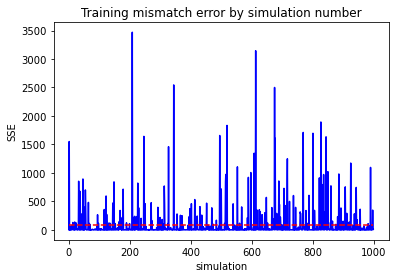

In [88]:
#MISMATCH ERRORS
plt.plot(test_results[1],color ="blue")
plt.plot(np.full((len(test_results[1]),),test_results[0]),color ="red",linestyle='--')
plt.xlabel("simulation")
plt.ylabel("SSE")
plt.title('Training mismatch error by simulation number')
plt.show

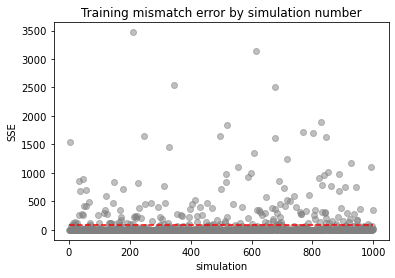

In [89]:
x=np.arange(len(test_results[1]))+1
y=test_results[1]
plt.scatter(x, y, c="grey", alpha=0.5)
plt.plot(np.full((len(test_results[1]),),test_results[0]),color ="red",linestyle='--')
plt.xlabel("simulation")
plt.ylabel("SSE")
plt.title('Training mismatch error by simulation number')
plt.show()

In [118]:
np.argwhere(test_results[1]>1500)

array([[  1],
       [208],
       [246],
       [344],
       [495],
       [519],
       [613],
       [675],
       [677],
       [769],
       [801],
       [827],
       [844]])

In [90]:
#TEST DATA PERFORMANCE (VISUALISATION)
weights_predictions_test_interim = test_results[2]
weights_predictions_test = np.reshape(weights_predictions_test_interim,(weights_predictions_test_interim.shape[0],weights_predictions_test_interim.shape[1]))
weights_predictions_test

array([[0.55513763, 0.48583302, 0.47246245, ..., 0.5668583 , 0.5638404 ,
        0.46297333],
       [0.6453447 , 0.51462245, 0.41731402, ..., 0.7850031 , 0.78361666,
        0.39846686],
       [0.5822514 , 0.52134055, 0.34658438, ..., 0.8161492 , 0.87031573,
        0.3934613 ],
       ...,
       [0.8443256 , 0.9988659 , 0.2744498 , ..., 0.9986139 , 0.7352738 ,
        0.02679993],
       [0.84205186, 0.99887896, 0.2805756 , ..., 0.99861723, 0.79933745,
        0.01805332],
       [0.8822939 , 0.99888515, 0.28781176, ..., 0.9986172 , 0.86999685,
        0.00990298]], dtype=float32)

In [91]:
#Weights range between 0 and 1
np.min(weights_predictions_test),np.max(weights_predictions_test)

(0.0007195117, 0.99888515)

In [126]:
#Allocations that would be done in practice 
#Analytical solutions with visibility up to time t
analytical_weights_test=np.full((test_data.shape[0],test_data.shape[1]),fill_value=0.0)

analytical_lag = 7
original_range=np.arange(test_data.shape[0])
new_range=np.array([])
i_mod_step_list=np.array([])
for i in original_range:
    if i%analytical_lag==0:
        i_mod = i
        i_mod_step_list=np.append(i_mod_step_list,i_mod)
    else:
        i_mod = i_mod_step_list[-1]
    new_range = np.append(new_range,i_mod)

new_range=new_range.astype(int)

for i in np.arange(len(new_range)):
    for j in np.arange(test_data.shape[1]):
        data_point_assets=test_data[new_range[i]][j]
        #data_point_liabilities=test_data[i][j]
        #print(data_point)
        t1=data_point_assets[0]
        t2=data_point_assets[1]
        tl=data_point_assets[2]
        analytical_weight= zc_immuniser(t1,t2,tl)[3]
        #print(analytical_weight)
        analytical_weights_test[i,j] = analytical_weight
analytical_weights_test.shape, analytical_weights_test

((30, 1000),
 array([[0.62949646, 0.48062901, 0.46748876, ..., 0.72064214, 0.70890892,
         0.45914773],
        [0.62949646, 0.48062901, 0.46748876, ..., 0.72064214, 0.70890892,
         0.45914773],
        [0.62949646, 0.48062901, 0.46748876, ..., 0.72064214, 0.70890892,
         0.45914773],
        ...,
        [0.60223417, 1.        , 0.33330689, ..., 1.        , 0.90125995,
         0.1726255 ],
        [0.83922933, 1.        , 0.28362709, ..., 1.        , 0.80993077,
         0.        ],
        [0.83922933, 1.        , 0.28362709, ..., 1.        , 0.80993077,
         0.        ]]))

In [127]:
#Allocations that would be done with perfect information(Perfect allocations)
#Analytical solutions with visibility up to time t
perfect_weights_test=np.full((test_data.shape[0],test_data.shape[1]),fill_value=0.0)
for i in np.arange(test_data.shape[0]):
    for j in np.arange(test_data.shape[1]):
        data_point_assets=test_data[i][j]
        data_point_liabilities=test_data[i][j]
        #print(data_point)
        t1=data_point_assets[0]
        t2=data_point_assets[1]
        tl=data_point_liabilities[2]
        perfect_weight= zc_immuniser(t1,t2,tl)[3]
        #print(analytical_weight)
        perfect_weights_test[i,j] = perfect_weight
perfect_weights_test.shape, perfect_weights_test

((30, 1000),
 array([[0.62949646, 0.48062901, 0.46748876, ..., 0.72064214, 0.70890892,
         0.45914773],
        [0.63460335, 0.51781068, 0.40736866, ..., 0.80782497, 0.80003081,
         0.38570786],
        [0.57797721, 0.51226784, 0.36266647, ..., 0.81359441, 0.88351884,
         0.41560714],
        ...,
        [0.83138654, 1.        , 0.2862942 , ..., 1.        , 0.74192441,
         0.        ],
        [0.83922933, 1.        , 0.28362709, ..., 1.        , 0.80993077,
         0.        ],
        [0.88335584, 1.        , 0.2925323 , ..., 1.        , 0.88483025,
         0.        ]]))

In [128]:
#COMPARISON
comparison_time_point = -1 
analytical_weights_final = analytical_weights_test[comparison_time_point,:]
perfect_weights_final = perfect_weights_test[comparison_time_point,:]
predicted_weights_final = weights_predictions_test[comparison_time_point,:]

predicted_less_perfect = predicted_weights_final - perfect_weights_final
analytical_less_perfect = analytical_weights_final - perfect_weights_final

predicted_weights_diff = np.sum(np.abs(predicted_less_perfect))
analytical_weights_diff = np.sum(np.abs(analytical_less_perfect))

#predicted_weights_vs_analytical=np.abs(predicted_weights_final - perfect_weights_final)/np.abs(analytical_weights_final - perfect_weights_final)
#predicted_weights_vs_analytical

In [129]:
predicted_weights_diff,analytical_weights_diff

(8.953035611979384, 32.57191791563978)

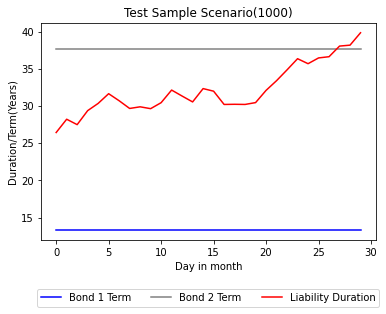

In [215]:
#Case visualisation
a1_vis = test_data[:,test_index,0]
a2_vis = test_data[:,test_index,1]
l_vis = test_data[:,test_index,2]
plt.plot(a1_vis,color = "blue",label = "Bond 1 Term")
plt.plot(a2_vis,color = "grey", label = "Bond 2 Term")
plt.plot(l_vis,color = "red", label = "Liability Duration")
plt.xlabel("Day in month")
plt.ylabel("Duration/Term(Years)")
plt.legend(loc="upper center",bbox_to_anchor=(0.5, -0.2),ncol = 3)
plt.title(f"Test Sample Scenario({test_index+1})")
plt.show
plt.savefig(f'output/rq2_1.png', dpi=300, bbox_inches="tight")

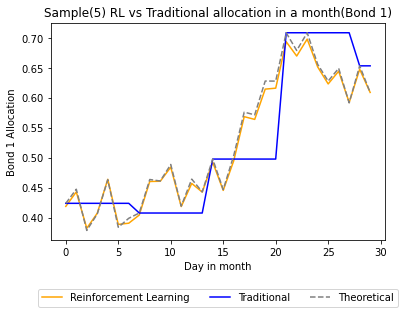

In [221]:
#TEST DATA PERFORMANCE (VISUALISATION)
#TRAINING DATA PERFORMANCE
#Bond 1 
test_index = 4
#x=np.arange(30)
plt.plot(weights_predictions_test[:,test_index],color = "orange",label="Reinforcement Learning")
plt.plot(analytical_weights_test[:,test_index],color = "blue", label = "Traditional")
plt.plot(perfect_weights_test[:,test_index],color = "grey", linestyle='--', label ="Theoretical")
#legend 
#plt.ylim(0,1.1)
plt.xlabel("Day in month")
plt.ylabel("Bond 1 Allocation")
#plt.ylim(0,1.1)
plt.title(f"Sample({test_index+1}) RL vs Traditional allocation in a month(Bond 1)")
plt.legend(loc="upper center",bbox_to_anchor=(0.5, -0.2),ncol = 3)
plt.show
plt.savefig(f'output/rq2_{test_index+1}b1.png', dpi=300, bbox_inches="tight")

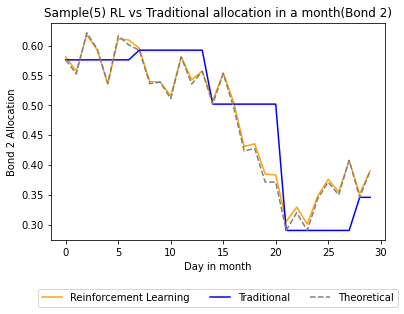

In [222]:
#bond 2
plt.plot(1-weights_predictions_test[:,test_index],color = "orange",label="Reinforcement Learning")
plt.plot(1-analytical_weights_test[:,test_index],color = "blue", label = "Traditional")
plt.plot(1-perfect_weights_test[:,test_index],color = "grey", linestyle='--', label ="Theoretical")
#legend 
#plt.ylim(0,1.1)
plt.xlabel("Day in month")
plt.ylabel("Bond 2 Allocation")
#plt.ylim(0,1.1)
plt.title(f"Sample({test_index+1}) RL vs Traditional allocation in a month(Bond 2)")
plt.legend(loc="upper center",bbox_to_anchor=(0.5, -0.2),ncol = 3)
plt.show
plt.savefig(f'output/rq2_{test_index+1}b2.png', dpi=300, bbox_inches="tight")

In [212]:
a1_vis

array([10.15585664, 10.15585664, 10.15585664, 10.15585664, 10.15585664,
       10.15585664, 10.15585664, 10.15585664, 10.15585664, 10.15585664,
       10.15585664, 10.15585664, 10.15585664, 10.15585664, 10.15585664,
       10.15585664, 10.15585664, 10.15585664, 10.15585664, 10.15585664,
       10.15585664, 10.15585664, 10.15585664, 10.15585664, 10.15585664,
       10.15585664, 10.15585664, 10.15585664, 10.15585664, 10.15585664])

In [213]:
a2_vis

array([33.10827703, 33.10827703, 33.10827703, 33.10827703, 33.10827703,
       33.10827703, 33.10827703, 33.10827703, 33.10827703, 33.10827703,
       33.10827703, 33.10827703, 33.10827703, 33.10827703, 33.10827703,
       33.10827703, 33.10827703, 33.10827703, 33.10827703, 33.10827703,
       33.10827703, 33.10827703, 33.10827703, 33.10827703, 33.10827703,
       33.10827703, 33.10827703, 33.10827703, 33.10827703, 33.10827703])

In [211]:
l_vis

array([23.37704043, 22.83616341, 24.41796859, 23.78342632, 22.47121008,
       24.29711336, 23.95144659, 23.74931017, 22.46181355, 22.51928369,
       21.88455806, 23.48412873, 22.44677448, 22.9379643 , 21.67691223,
       22.84975895, 21.54371656, 19.87485556, 19.97768855, 18.67976342,
       18.6828008 , 16.8252707 , 17.50814194, 16.82533274, 18.03802731,
       18.68049841, 18.19051601, 19.51772774, 18.09596039, 19.11746962])

Diff Mean: 0.05463145390234028 Diff Std: 0.28141489704277506


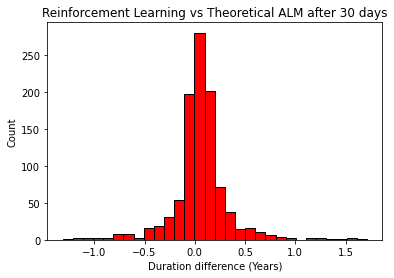

In [229]:
#REINFORCEMENT LEARNING DURATION VS THEORETICAL DURATION 
comparison_time_point = 29
duration_diff_agg=[]
for test_index in np.arange(test_data.shape[1]):
    test_asset_duration=weights_predictions_test[comparison_time_point,test_index]*test_data[comparison_time_point,test_index,0] + (1-weights_predictions_test[comparison_time_point,test_index])*test_data[comparison_time_point,test_index,1]
    test_asset_duration_perfect=perfect_weights_test[comparison_time_point,test_index]*test_data[comparison_time_point,test_index,0] + (1-perfect_weights_test[comparison_time_point,test_index])*test_data[comparison_time_point,test_index,1]
    duration_diff=(test_asset_duration-test_asset_duration_perfect)#/test_asset_duration_analytical
    #duration_diff_abs=np.abs(duration_diff)
    #duration_diff_mean=np.mean(duration_diff_abs)
    duration_diff_agg.append(duration_diff)
print("Diff Mean:", np.mean(duration_diff_agg),"Diff Std:",np.std(duration_diff_agg))
plt.xlabel("Duration difference (Years)")
plt.ylabel("Count")
#plt.ylim(0,1.1)
plt.title(f"Reinforcement Learning vs Theoretical ALM after {comparison_time_point+1} days")
plt.hist(duration_diff_agg,density=0,bins=30,color="red",ec="black")
plt.savefig(f'output/rq2_ag1.png', dpi=300, bbox_inches="tight")

Diff Mean: 0.03125783577285785 Diff Std: 0.9210453415820283


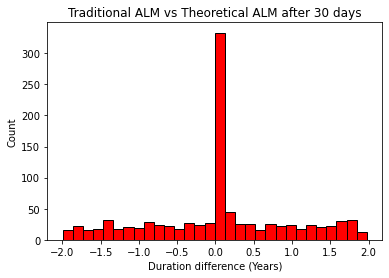

In [237]:
#TRADITIONAL ALM DURATION VS THEORETICAL ALM DURATION
#comparison_time_point = 28
duration_diff_agg=[]
for test_index in np.arange(test_data.shape[1]):
    test_asset_duration_analytical=analytical_weights_test[comparison_time_point,test_index]*test_data[comparison_time_point,test_index,0] + (1-analytical_weights_test[comparison_time_point,test_index])*test_data[comparison_time_point,test_index,1]
    test_asset_duration_perfect=perfect_weights_test[comparison_time_point,test_index]*test_data[comparison_time_point,test_index,0] + (1-perfect_weights_test[comparison_time_point,test_index])*test_data[comparison_time_point,test_index,1]
    duration_diff=(test_asset_duration_analytical-test_asset_duration_perfect)#/test_asset_duration_analytical
    #duration_diff_abs=np.abs(duration_diff)
    #duration_diff_mean=np.mean(duration_diff_abs)
    duration_diff_agg.append(duration_diff)
print("Diff Mean:", np.mean(duration_diff_agg),"Diff Std:",np.std(duration_diff_agg))
plt.xlabel("Duration difference (Years)")
plt.ylabel("Count")
#plt.ylim(0,1.1)
plt.title(f"Traditional ALM vs Theoretical ALM after {comparison_time_point+1} days")
plt.hist(duration_diff_agg,density=0,bins=30,color="red",ec="black")
plt.savefig('output/rq2_ag2.png', dpi=300, bbox_inches="tight")


CUMULATIVE COMPARISONS

In [225]:
#CUMULATIVE REINFORCEMENT LEARNING DURATION VS THEORETICAL DURATION 
#comparison_time_point = 28

def rl_vs_theoretical_comp(comparison_time_point):
    duration_diff_agg=[]
    for test_index in np.arange(test_data.shape[1]):
        test_asset_duration=weights_predictions_test[comparison_time_point,test_index]*test_data[comparison_time_point,test_index,0] + (1-weights_predictions_test[comparison_time_point,test_index])*test_data[comparison_time_point,test_index,1]
        test_asset_duration_perfect=perfect_weights_test[comparison_time_point,test_index]*test_data[comparison_time_point,test_index,0] + (1-perfect_weights_test[comparison_time_point,test_index])*test_data[comparison_time_point,test_index,1]
        duration_diff=np.abs(test_asset_duration-test_asset_duration_perfect)
   
        duration_diff_agg.append(duration_diff)

    mean_duration_diff=np.mean(duration_diff_agg)
    std_duration_diff=np.std(duration_diff_agg)

    return np.array([mean_duration_diff,std_duration_diff])

#rl_vs_theoretical_comp(28)


rl_performances = []
for time_point in np.arange(test_data.shape[0]):
    ith_mean=rl_vs_theoretical_comp(time_point)[0]
    rl_performances = np.append(rl_performances,ith_mean)

# plt.plot(rl_performances,color = "orange")
# plt.title("Relative Aggregate RL performance")


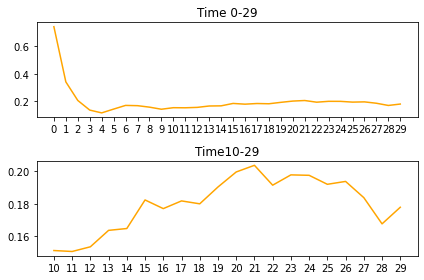

In [226]:
#Performance plots Mean 
cut_off_time = 10
figure, axis = plt.subplots(2, 1,)
axis[0].plot(np.arange(len(rl_performances)),rl_performances,color = "orange")
axis[0].set_title("Time 0-29")
axis[0].set_xticks(np.arange(len(rl_performances)))


axis[1].plot(np.arange(len(rl_performances[cut_off_time:]))+cut_off_time,rl_performances[cut_off_time:],color = "orange")
axis[1].set_title(f"Time{cut_off_time}-29")
axis[1].set_xticks(np.arange(cut_off_time,len(rl_performances)))


figure.tight_layout()
plt.show()


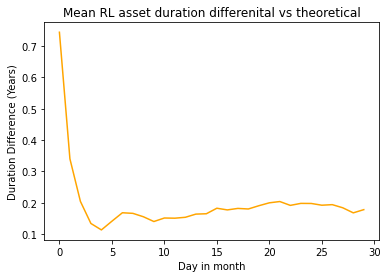

In [227]:
#Performance plots Mean all time
plt.plot(np.arange(len(rl_performances)),rl_performances,color = "orange")
plt.title("Mean RL asset duration differenital vs theoretical")
#plt.xticks(np.arange(len(rl_performances))+1)

plt.xlabel("Day in month")
plt.ylabel("Duration Difference (Years)")
plt.savefig('output/rq2_ag3.png', dpi=300, bbox_inches="tight")


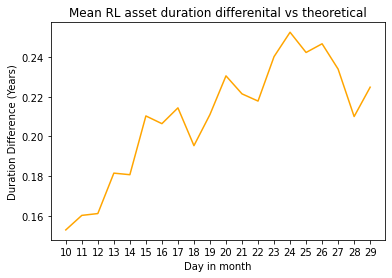

In [210]:
#Performance plots 10+
#Performance plots Mean all time
cut_off_time = 10
plt.plot(np.arange(len(rl_performances[cut_off_time:]))+cut_off_time,rl_performances[cut_off_time:],color = "orange")
plt.title("Mean RL asset duration differenital vs theoretical")
plt.xticks(np.arange(cut_off_time,len(rl_performances)))

plt.xlabel("Day in month")
plt.ylabel("Duration Difference (Years)")

plt.savefig('output/rq2_ag4.png',dpi=300, bbox_inches="tight")


array([0.15115788, 0.15056625, 0.15346223, 0.1636051 , 0.16474516,
       0.18237439, 0.17702754, 0.18178072, 0.17998469, 0.1903682 ,
       0.19963842, 0.2037511 , 0.19149072, 0.1978457 , 0.19757708,
       0.19203152, 0.19381108, 0.1837894 , 0.16761516, 0.17786466])

In [239]:
#Traditional mean aboslut value difference 10+
np.mean(rl_performances[cut_off_time:]),np.std(rl_performances[cut_off_time:])

(0.18002435074554976, 0.016195911351196718)

In [197]:
#STANDARD DEVIATION
# rl_performances = []
# for time_point in np.arange(test_data.shape[0]):
#     ith_mean=rl_vs_theoretical_comp(time_point)[1]
#     rl_performances = np.append(rl_performances,ith_mean)

# plt.title("RL performance standard deviation")
# plt.plot(rl_performances,color = "orange")

In [149]:
#CUMULATIVE TRADITION  VS THEORETICAL DURATION 
#comparison_time_point = 28

def traditional_vs_theoretical_comp(comparison_time_point):
    duration_diff_agg=[]
    for test_index in np.arange(test_data.shape[1]):
        test_asset_duration_analytical=analytical_weights_test[comparison_time_point,test_index]*test_data[comparison_time_point,test_index,0] + (1-analytical_weights_test[comparison_time_point,test_index])*test_data[comparison_time_point,test_index,1]
        test_asset_duration_perfect=perfect_weights_test[comparison_time_point,test_index]*test_data[comparison_time_point,test_index,0] + (1-perfect_weights_test[comparison_time_point,test_index])*test_data[comparison_time_point,test_index,1]
        duration_diff=np.abs(test_asset_duration_analytical-test_asset_duration_perfect)
    
        duration_diff_agg.append(duration_diff)

    mean_duration_diff=np.mean(duration_diff_agg)
    std_duration_diff=np.std(duration_diff_agg)

    return np.array([mean_duration_diff,std_duration_diff])

#traditional_vs_theoretical_comp(28)

traditional_performances = []
for time_point in np.arange(test_data.shape[0]):
    ith_mean=traditional_vs_theoretical_comp(time_point)[0]
    traditional_performances = np.append(traditional_performances,ith_mean)

# plt.plot(traditional_performances[10:],color = "blue")
# plt.title("Relative Aggregate traditional performance mean")
#plt.xticks(np.array([10,11,12,13,14,15,16,27]))


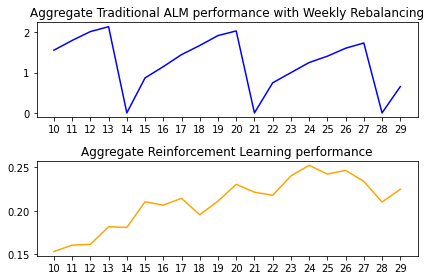

In [150]:
#COMPARISON BETWEEN RL AND TRADITIONAL ALM PERFORMANCE 
figure, axis = plt.subplots(2, 1)

y_t = traditional_performances[cut_off_time:]
x_t = np.arange(len(traditional_performances[cut_off_time:]))+cut_off_time
axis[0].plot(x_t,y_t,color = "blue")
axis[0].set_title("Aggregate Traditional ALM performance with Weekly Rebalancing")
axis[0].set_xticks(np.arange(cut_off_time,len(traditional_performances)))

y_rl = rl_performances[cut_off_time:]
x_rl = np.arange(len(rl_performances[cut_off_time:]))+cut_off_time
axis[1].plot(x_rl,y_rl,color = "orange")
axis[1].set_title("Aggregate Reinforcement Learning performance")
axis[1].set_xticks(np.arange(cut_off_time,len(rl_performances)))

# y_t = traditional_performances[cut_off_time:]
# x_t = np.arange(len(traditional_performances[cut_off_time:]))+cut_off_time
# axis[0,1].plot(x_t,y_t,color = "blue")
# axis[0,1].set_title("Aggregate Traditional ALM performance with Weekly Rebalancing")
# axis[0,1].set_xticks(np.arange(cut_off_time,len(traditional_performances)))

# y_rl = rl_performances[cut_off_time:]
# x_rl = np.arange(len(rl_performances[cut_off_time:]))+cut_off_time
# axis[1,1].plot(x_rl,y_rl,color = "orange")
# axis[1,1].set_title("Aggregate Reinforcement Learning performance")
# axis[1,1].set_xticks(np.arange(cut_off_time,len(rl_performances)))

figure.tight_layout()
plt.show()


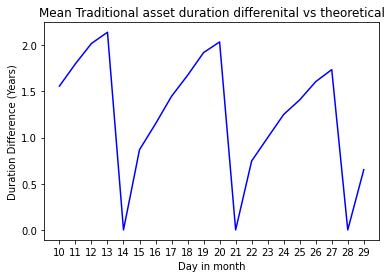

In [209]:
#COMPARISON BETWEEN RL AND TRADITIONAL ALM PERFORMANCE 

y_t = traditional_performances[cut_off_time:]
x_t = np.arange(len(traditional_performances[cut_off_time:]))+cut_off_time
plt.plot(x_t,y_t,color = "blue")
plt.title("Mean Traditional asset duration differenital vs theoretical")
plt.xticks(np.arange(cut_off_time,len(traditional_performances)))

plt.xlabel("Day in month")
plt.ylabel("Duration Difference (Years)")

plt.savefig('output/rq2_ag5.png', dpi=300, bbox_inches="tight")


In [232]:
#Traditional mean aboslut value difference 10+
np.mean(y_t)

1.2503603258050258

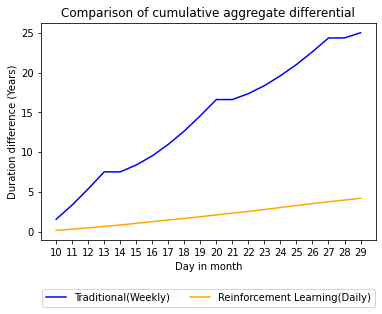

In [201]:
#figure, axis = plt.subplots(2, 1)

y_t_cum = np.cumsum(y_t)
x_t = np.arange(len(traditional_performances[cut_off_time:]))+cut_off_time
plt.plot(x_t,y_t_cum,color = "blue",label = "Traditional(Weekly)")

y_rl_cum = np.cumsum(y_rl)
plt.plot(x_rl,y_rl_cum,color = "orange", label = "Reinforcement Learning(Daily)")
plt.xlabel("Day in month")
plt.ylabel("Duration difference (Years)")
plt.title("Comparison of cumulative aggregate differential")
plt.xticks(np.arange(cut_off_time,len(rl_performances)))

plt.legend(loc="upper center",bbox_to_anchor=(0.5, -0.2),ncol = 3)

plt.savefig('output/rq2_ag6.png', dpi=300, bbox_inches="tight")
plt.show()

In [234]:
y_t_cum

array([ 1.55695473,  3.35600935,  5.3748877 ,  7.51522609,  7.51522609,
        8.3838702 ,  9.5328933 , 10.97985421, 12.65375751, 14.57395724,
       16.60918447, 16.60918447, 17.35570063, 18.35499488, 19.6053545 ,
       21.01348549, 22.61923874, 24.3549819 , 24.3549819 , 25.00720652])

In [236]:
y_rl_cum

array([0.15289381, 0.3131113 , 0.47424681, 0.65575525, 0.83647307,
       1.04680489, 1.25324521, 1.46764626, 1.6630044 , 1.87406024,
       2.10458656, 2.3260431 , 2.5438688 , 2.78408303, 3.03659154,
       3.27890519, 3.52560025, 3.75952762, 3.96955955, 4.19437748])